In [30]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


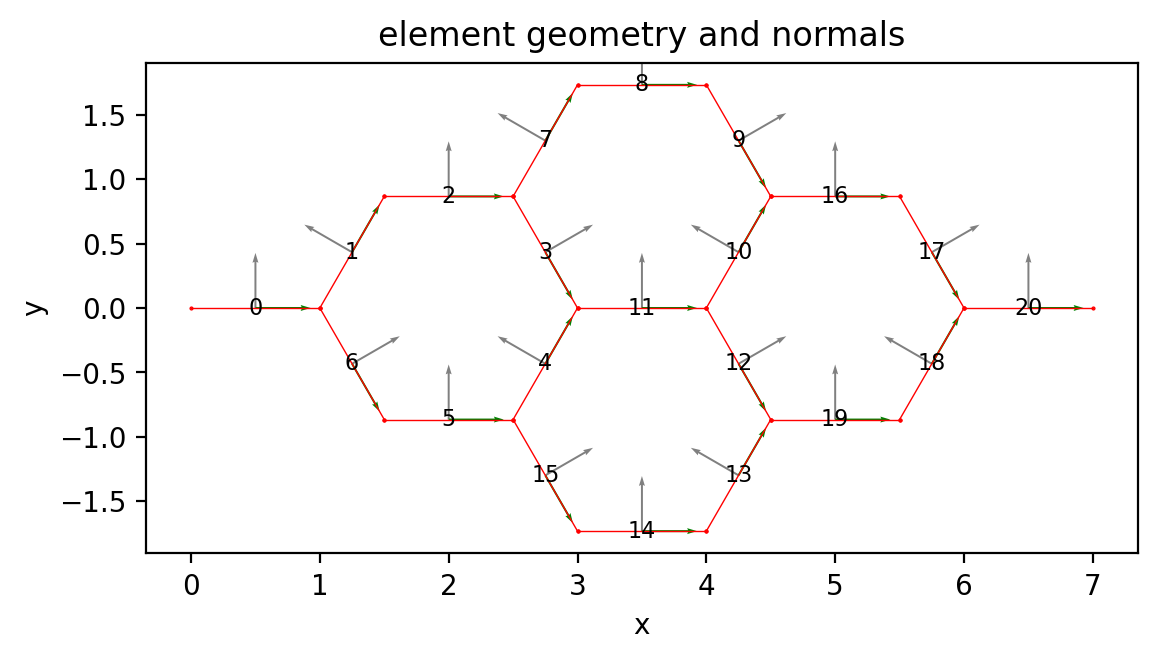

In [31]:
# Honeycomb geometry
dx = np.cos(np.deg2rad(60))
dy = np.sin(np.deg2rad(60))
els = bemcs.initialize_els()

els.x1 = np.array(
    [
        0,
        1,
        1 + dx,
        2 + dx,
        2 + 2 * dx,
        2 + dx,
        1 + dx,
        2 + dx,
        2 + 2 * dx,
        3 + 2 * dx,
        3 + 3 * dx,
        3 + 2 * dx,
        3 + 2 * dx,
        3 + 3 * dx,
        3 + 2 * dx,
        2 + 2 * dx,
        3 + 3 * dx,
        4 + 3 * dx,
        4 + 4 * dx,
        4 + 3 * dx,
        4 + 4 * dx,
    ]
)
els.y1 = np.array(
    [
        0,
        0,
        dy,
        dy,
        0,
        -dy,
        -dy,
        dy,
        2 * dy,
        2 * dy,
        dy,
        0,
        0,
        -dy,
        -2 * dy,
        -2 * dy,
        dy,
        dy,
        0,
        -dy,
        0,
    ]
)
els.x2 = np.array(
    [
        1,
        1 + dx,
        2 + dx,
        2 + 2 * dx,
        2 + dx,
        1 + dx,
        1,
        2 + 2 * dx,
        3 + 2 * dx,
        3 + 3 * dx,
        3 + 2 * dx,
        2 + 2 * dx,
        3 + 3 * dx,
        3 + 2 * dx,
        2 + 2 * dx,
        2 + dx,
        4 + 3 * dx,
        4 + 4 * dx,
        4 + 3 * dx,
        3 + 3 * dx,
        5 + 4 * dx,
    ]
)
els.y2 = np.array(
    [
        0,
        dy,
        dy,
        0,
        -dy,
        -dy,
        0,
        2 * dy,
        2 * dy,
        dy,
        0,
        0,
        -dy,
        -2 * dy,
        -2 * dy,
        -dy,
        dy,
        0,
        -dy,
        -dy,
        0,
    ]
)

bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)